<a href="https://colab.research.google.com/github/jeshraghian/snntorch/blob/master/examples/tutorial_7_neuromorphic_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt
from snntorch import spikegen


import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

# Training Parameters
batch_size=128
data_path='/data/mnist'
num_classes = 10  # MNIST has 10 output classes
num_steps = 100
TAU = 5
THRESHOLD = 0.1
beta = 0.5

PATH = "cnn_snn_mnist_latency_tau_5_thresh_0_1_beta_0_5_num_steps_100.pt"

# Torch Variables
dtype = torch.float

from torchvision import datasets, transforms

# Define a transform
transform = transforms.Compose([
            transforms.Resize((32,32)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# device = torch.device("cpu")

# neuron and simulation parameters
spike_grad = surrogate.atan()

#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5), #in=1x[32x32] out=12x[28x28]
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2), #in=12x[28x28] out=12x[14x14]
                    nn.Conv2d(12, 32, 5),#in=12x[14x14] out=32x[10x10]
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2), #in=32x[10x10] out=32x[5x5]
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10), 
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [3]:
# this time, we won't return membrane as we don't need it 

def forward_pass(net, data):  
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(data.size(0)):  # data.size(0) = number of time steps
      spk_out, mem_out = net(data[step])
      spk_rec.append(spk_out)
  
  return torch.stack(spk_rec)

In [4]:
optimizer = torch.optim.Adam(net.parameters(), lr=2e-2, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss()
# loss_fn = SF.mse_temporal_loss()

In [5]:
num_epochs = 5
num_iters = 50

loss_hist = []
acc_hist = []

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
#         data = spikegen.rate(data, num_steps=num_steps)
        data = spikegen.latency(data, num_steps=num_steps, tau=5, threshold=THRESHOLD, clip=True, normalize=True, linear=True)


        targets = targets.to(device)

        net.train()
        spk_rec = forward_pass(net, data)
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())
 
        print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

        acc = SF.accuracy_rate(spk_rec, targets) 
        acc_hist.append(acc)
        print(f"Accuracy: {acc * 100:.2f}%\n")

#         This will end train÷ing after 50 iterations by default
        if i == num_iters:
          break

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 0, Iteration 0 
Train Loss: 10.00
Accuracy: 12.50%

Epoch 0, Iteration 1 
Train Loss: 10.00
Accuracy: 7.81%

Epoch 0, Iteration 2 
Train Loss: 10.00
Accuracy: 10.16%

Epoch 0, Iteration 3 
Train Loss: 10.00
Accuracy: 10.16%

Epoch 0, Iteration 4 
Train Loss: 10.00
Accuracy: 10.16%

Epoch 0, Iteration 5 
Train Loss: 9.96
Accuracy: 12.50%

Epoch 0, Iteration 6 
Train Loss: 9.87
Accuracy: 9.38%

Epoch 0, Iteration 7 
Train Loss: 9.54
Accuracy: 15.62%

Epoch 0, Iteration 8 
Train Loss: 9.32
Accuracy: 10.94%

Epoch 0, Iteration 9 
Train Loss: 9.13
Accuracy: 17.19%

Epoch 0, Iteration 10 
Train Loss: 9.68
Accuracy: 25.78%

Epoch 0, Iteration 11 
Train Loss: 9.08
Accuracy: 32.03%

Epoch 0, Iteration 12 
Train Loss: 8.96
Accuracy: 25.00%

Epoch 0, Iteration 13 
Train Loss: 8.91
Accuracy: 31.25%

Epoch 0, Iteration 14 
Train Loss: 9.11
Accuracy: 32.03%

Epoch 0, Iteration 15 
Train Loss: 9.06
Accuracy: 27.34%

Epoch 0, Iteration 16 
Train Loss: 8.97
Accuracy: 24.22%

Epoch 0, Iteration 17

Epoch 2, Iteration 40 
Train Loss: 4.25
Accuracy: 78.91%

Epoch 2, Iteration 41 
Train Loss: 4.65
Accuracy: 71.88%

Epoch 2, Iteration 42 
Train Loss: 4.29
Accuracy: 75.78%

Epoch 2, Iteration 43 
Train Loss: 3.99
Accuracy: 80.47%

Epoch 2, Iteration 44 
Train Loss: 3.78
Accuracy: 82.03%

Epoch 2, Iteration 45 
Train Loss: 4.32
Accuracy: 75.78%

Epoch 2, Iteration 46 
Train Loss: 3.94
Accuracy: 87.50%

Epoch 2, Iteration 47 
Train Loss: 4.37
Accuracy: 80.47%

Epoch 2, Iteration 48 
Train Loss: 3.83
Accuracy: 85.16%

Epoch 2, Iteration 49 
Train Loss: 4.15
Accuracy: 80.47%

Epoch 2, Iteration 50 
Train Loss: 4.51
Accuracy: 76.56%

Epoch 3, Iteration 0 
Train Loss: 4.47
Accuracy: 81.25%

Epoch 3, Iteration 1 
Train Loss: 4.09
Accuracy: 80.47%

Epoch 3, Iteration 2 
Train Loss: 4.38
Accuracy: 75.00%

Epoch 3, Iteration 3 
Train Loss: 4.00
Accuracy: 78.91%

Epoch 3, Iteration 4 
Train Loss: 3.88
Accuracy: 82.81%

Epoch 3, Iteration 5 
Train Loss: 4.19
Accuracy: 77.34%

Epoch 3, Iteration 6

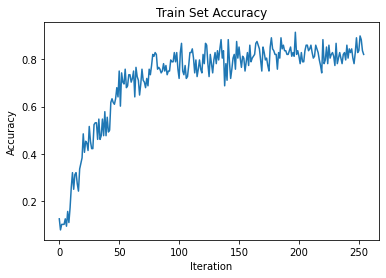

In [6]:
import matplotlib.pyplot as plt

# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(acc_hist)
plt.title("Train Set Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# load the pretrained model

THRESHOLD = 0.99
beta = 0.5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")


PATH = "snn_mnist_latency_tau_5_thresh_0_99_beta_0_5_num_steps_100.pt"

model_save_path = PATH
net = nn.Sequential(nn.Conv2d(1, 12, 5), #in=1x[32x32] out=12x[28x28]
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2), #in=12x[28x28] out=12x[14x14]
                    nn.Conv2d(12, 32, 5),#in=12x[14x14] out=32x[10x10]
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2), #in=32x[10x10] out=32x[5x5]
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10), 
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)
net.load_state_dict(torch.load(model_save_path))
net.eval()

In [7]:
def batch_accuracy(data_loader, net):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()
    
    data_loader = iter(data_loader)
    for data, targets in data_loader:
      data = data.to(device)
      targets = targets.to(device)
        
      data = spikegen.latency(data, num_steps=num_steps, tau=5, threshold=THRESHOLD, clip=True, normalize=True, linear=True)

      spk_rec = forward_pass(net, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [8]:
test_acc = batch_accuracy(test_loader, net)
print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 82.67%


In [ ]:
torch.save(net.state_dict(), PATH)

In [ ]:
spk_rec = forward_pass(net, data)

In [ ]:
from IPython.display import HTML

idx = 1

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels, 
                        animate=True, interpolate=1)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")

In [9]:
class SaveOutput:
    def __init__(self):
        self.inputs = []
        self.outputs = []
        
    def __call__(self, module, module_in, module_out):
        self.outputs.append(module_out)
        self.inputs.append(module_in)
        
    def clear(self):
        self.outputs = []
        self.inputs = []

In [10]:
# get a data batch of size 1 for simplicity
THRESHOLD = 0.1
# PATH = "snn_mnist_latency_tau_5_thresh_0_1_beta_0_5_num_steps_100.pt"

test_loader_batch_size_one = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
for data, targets in test_loader_batch_size_one:
    print(data.size())
    data = spikegen.latency(data, num_steps=num_steps, tau=5, threshold=THRESHOLD, clip=True, normalize=True, linear=True)
    print(data.size())
    print(targets)
    break

# input_data_spikes = torch.count_nonzero(data)


torch.Size([128, 1, 32, 32])
torch.Size([100, 128, 1, 32, 32])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4,
        1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2,
        5, 4, 7, 6, 7, 9, 0, 5])


In [ ]:
# load the pretrained model

model_save_path = PATH
net = nn.Sequential(nn.Conv2d(1, 12, 5), #in=1x[32x32] out=12x[28x28]
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2), #in=12x[28x28] out=12x[14x14]
                    nn.Conv2d(12, 32, 5),#in=12x[14x14] out=32x[10x10]
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.MaxPool2d(2), #in=32x[10x10] out=32x[5x5]
                    nn.Flatten(),
                    nn.Linear(32*5*5, 10), 
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)
net.load_state_dict(torch.load(model_save_path))
net.eval()

In [11]:
save_output = SaveOutput()

hook_handles = []

for layer in net.modules():
    if isinstance(layer, snn.Leaky):
        handle = layer.register_forward_hook(save_output)
        hook_handles.append(handle)

In [15]:
save_output.clear()
data = data.to(device)
spk_rec = forward_pass(net, data)

In [17]:
len(save_output.outputs)

300

In [19]:
# i = 0
leaky1_none_zero_outputs = 0
leaky2_none_zero_outputs = 0
leaky3_none_zero_outputs = 0

for i in range(0, len(save_output.outputs), 3):
    l1 = save_output.outputs[i]
    l2 = save_output.outputs[i+1]
    l3 = save_output.outputs[i+2][0]
#     print("l1 size", l1.size())
    leaky1_none_zero_outputs += torch.count_nonzero(l1)
#     print("l1", l1)
#     print("l2 size", l2.size())
    leaky2_none_zero_outputs += torch.count_nonzero(l2)
#     print("l2", l2)
#     print("l3 size", l3.size())
    leaky3_none_zero_outputs += torch.count_nonzero(l3)
#     print("l3", l3)
    
#     if i == 2:
#     break
input_data_spikes = torch.count_nonzero(data)

print(f'input_data_spikes = {input_data_spikes}')
print(f'leaky1_none_zero_outputs {leaky1_none_zero_outputs}')
print(f'leaky2_none_zero_outputs {leaky2_none_zero_outputs}')
print(f'leaky3_none_zero_outputs {leaky3_none_zero_outputs}')

input_data_spikes = 24599
leaky1_none_zero_outputs 2194810
leaky2_none_zero_outputs 7353625
leaky3_none_zero_outputs 14621


In [ ]:
#  Initialize Network
data_in = data[0]
print("in",data_in.size())

c1_out = nn.Conv2d(1, 12, 5)(data_in)
# print("Conv2d",c1_out.size())

l1_out = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)(c1_out)
print("Leaky",l1_out.size())

p1_out = nn.MaxPool2d(2)(l1_out)
# print("MaxPool2d",p1_out.size())

c2_out = nn.Conv2d(12, 32, 5)(p1_out)
# print("Conv2d",c2_out.size())

l2_out = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)(c2_out)
print("Leaky",l2_out.size())

p2_out = nn.MaxPool2d(2)(l2_out)
# print("MaxPool2d",p2_out.size())

f1 = nn.Flatten()
# print("Flatten",f1_out.size())

li1_out = nn.Linear(32*5*5, 10)(f1(p2_out))
# print("Linear",li1_out.size())

l3_out = snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True)(li1_out)
print("Leaky",l3_out.size())

#                     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#                     nn.MaxPool2d(2), #in=12x[28x28] out=12x[14x14]
#                     nn.Conv2d(12, 32, 5),#in=12x[14x14] out=32x[10x10]
#                     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
#                     nn.MaxPool2d(2), #in=32x[10x10] out=32x[5x5]
#                     nn.Flatten(),
#                     nn.Linear(32*5*5, 10), 
#                     snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
#                     ).to(device)